In [16]:
import selfies as sf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import NamedTuple
from dataclasses import dataclass, asdict
import json

@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_size: int
        
config = Config(128, 249455, 64, 10000, 256, 128)

## Get Vocab

In [17]:
data_url = 'https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt'

pd_data = pd.read_csv(data_url)
print('Total data size', len(pd_data))
selfies_list = list(map(sf.encoder, pd_data.iloc[:config.example_number, 0]))
all_selfies_symbols = ['[nop]']
all_selfies_symbols += sf.get_alphabet_from_selfies(selfies_list)
vocab_stoi = {o:i for o,i in zip(all_selfies_symbols, range(len(all_selfies_symbols)))}

Total data size 249455


In [18]:
encoded = [sf.selfies_to_encoding(s, vocab_stoi)[0] for s in selfies_list]
print('Number of sequences used', len(encoded))

Number of sequences used 249455


## Build data

In [19]:
# now get sequences
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')

# Now build dataset
seqs_data = tf.data.Dataset.from_tensor_slices((padded_seqs,))

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

data = seqs_data.map(split_input_target)
data = data.shuffle(config.buffer_size).batch(config.batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
for d in data:
    print(d[0].shape, d[1].shape)
    example = d[0]
    example_y = d[1]
    break

(64, 71) (64, 71)


## Build Model

In [20]:
x = tf.keras.Input(shape=(None,))
ex = tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True)(x)
# reset_after - TFJS requires this as false
h = tf.keras.layers.GRU(config.rnn_size, return_sequences=True, reset_after=False, stateful=False)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
model = tf.keras.Model(inputs=x, outputs=yhat)

## Try Model

In [21]:
yhat = model(example)

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 256)         32768     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         147840    
_________________________________________________________________
dense_2 (Dense)              (None, None, 128)         16512     
Total params: 197,120
Trainable params: 197,120
Non-trainable params: 0
_________________________________________________________________


## Train

In [24]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(tf.optimizers.Adam(1e-2), loss=[loss, None])
result = model.fit(data, epochs=3)

Epoch 1/3
3897/3897 [==============================] - 287s 73ms/step - loss: 0.6333
Epoch 2/3
3897/3897 [==============================] - 286s 73ms/step - loss: 0.5962
Epoch 3/3
3897/3897 [==============================] - 295s 76ms/step - loss: 0.5891


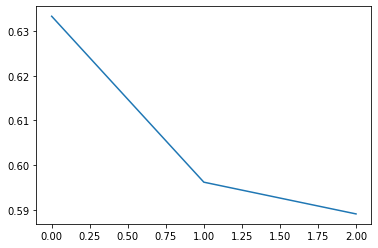

In [25]:
plt.plot(result.history['loss'])
plt.show()

## Build Inference Model

In [26]:
x = tf.keras.Input(shape=(None,), batch_size=1)
ex = tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True)(x)
h = tf.keras.layers.GRU(config.rnn_size, return_sequences=False, reset_after=False, stateful=True)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
inference_model = tf.keras.Model(inputs=x, outputs=yhat)

inference_model.set_weights(model.get_weights())

## Try Inference Model

In [27]:
start = np.zeros((1, 10))
start[0, 0] = 1
start[0,1] = 2
inference_model(start);

## Save Model

In [28]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(inference_model, '../model')

## Save Config

In [29]:
import json

model_info = asdict(config)
model_info['stoi'] = vocab_stoi
model_info['vocab'] = all_selfies_symbols


with open('../src/lib/model_info.json', 'w') as f:
    json.dump(model_info, f)